# 4.2-a How does the number of classes affect accuracy?

In [1]:
import os
import sys
import datetime
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

import models
import report
from dataset import Dataset
from report import Reporter
from trainer import Trainer
from batch_encoder import Dataset

from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, TimeDistributed, Flatten, Dot, Softmax, Lambda, RepeatVector, Multiply, Permute, Reshape, BatchNormalization

/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/atila.alr/.local/lib/python3.6/site-packages/tensorflow/python/framework/dty

In [2]:
tf.__version__, tf.keras.__version__

('1.14.0', '2.2.4-tf')

In [3]:
tf.test.is_gpu_available(), tf.test.is_built_with_cuda()

(False, False)

In [4]:
raw_dataset_folder='govdocs1/sample200'
minimum=200
maximum=200
result_dir = 'results/4.2a-nclasses'

In [5]:
rawset = Dataset.new_from_folders(raw_dataset_folder)
rawset = rawset.filter(lambda x: rawset.category_from(x) not in ['text', 'unk'])
rawset = rawset.filter_min_max(200, 200)

In [6]:
def CLD(classes, len_byte_vector):
    last = l0 = Input(shape=(512,len_byte_vector))
    last = Conv1D(256, (16,), strides=16)(last)
    last = LSTM(128)(last)
    last = Dense(classes)(last)
    last = Activation('softmax')(last)
    name = sys._getframe().f_code.co_name
    model = tf.keras.Model([l0], last, name=name)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['binary_accuracy', 'categorical_accuracy'])
    return model

In [7]:
def train_nclasses(rawset, reporter, iterations=1):
    for it in range(iterations):
        for n in range(2, len(rawset.categories)+1):
            cats = random.sample(rawset.by_category().keys(), n)
            print(n, cats)
            myset = rawset.filter(lambda x: rawset.category_from(x) in cats)
            myset.rebuild_categories()
            tset, vset = myset.rnd_split_fraction_by_category(0.5)

            model = CLD(n, 256)
            result = Trainer(
                model,
                xs_encoder='one_hot',
                batch_size=100,
                steps_per_epoch=28,
                validation_steps=28,
                patience=10,
            ).train(tset, vset)
            r.line(n=n,
                cats=','.join(cats),
                val_categorical_accuracy=result.history.history['val_categorical_accuracy'][-1],
            )

# Train models

In [8]:
if os.path.exists(result_dir + "/nclasses.tsv"):
    os.remove(result_dir + "/nclasses.tsv")
r = report.Reporter2(result_dir + '/nclasses.tsv')
train_nclasses(rawset, r, 5)
r.close()

2 ['f', 'wp']
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
3 ['rtf', 'pps', 'csv']
4 ['pptx', 'csv', 'dwf', 'sql']
5 ['log', 'kmz', 'wp', 'dbase3', 'hlp']
6 ['jpg', 'swf', 'f', 'xls', 'dbase3', 'wp']
7 ['sql', 'ps', 'f', 'txt', 'dbase3', 'gif', 'wp']
8 ['dwf', 'doc', 'swf', 'dbase3', 'sql', 'gif', 'csv', 'hlp']
9 ['pdf', 'eps', 'java', 'html', 'ppt', 'csv', 'xml', 'swf', 'wp']
10 ['gz', 'xls', 'kmz', 'sql', 'doc', 'pps', 'pptx', 'hlp', 'rtf', 'f']
11 ['ps', 'wp', 'jpg', 'ppt', 'rtf', 'dwf', 'hlp', 'csv', 'kmz', 'pps', 'java']
12 ['sql', 'xls', 'f', 'xml', 'pptx', 'log', 'png', 'kmz', 'gz', 'swf', 'pps', 'gif']
13 ['png', 'pptx', 'csv', 'dwf', 'pdf', 'swf', 'txt', 'xml', 'pps', 'doc', 'wp', 'ps', 'ppt']
14 ['dwf', 'csv', 'dbase3', 'jpg', 'png', 'f', 'wp', 'xls', 'gz', 'sql', 'eps', 'pps', 'html', 'ps']
15 ['f', 'dbase3', '

22 ['png', 'doc', 'java', 'xml', 'eps', 'hlp', 'rtf', 'f', 'csv', 'pdf', 'gz', 'html', 'ppt', 'dbase3', 'pps', 'xls', 'gif', 'log', 'jpg', 'swf', 'sql', 'kmz']
23 ['dwf', 'kmz', 'rtf', 'f', 'pdf', 'xml', 'html', 'ps', 'swf', 'csv', 'pps', 'pptx', 'xls', 'jpg', 'sql', 'ppt', 'log', 'eps', 'gif', 'wp', 'doc', 'hlp', 'dbase3']
24 ['gif', 'xls', 'gz', 'dwf', 'dbase3', 'xml', 'log', 'pptx', 'kml', 'csv', 'kmz', 'txt', 'hlp', 'rtf', 'java', 'jpg', 'html', 'ppt', 'f', 'eps', 'png', 'pps', 'pdf', 'ps']
25 ['jpg', 'xls', 'gif', 'txt', 'png', 'hlp', 'doc', 'dwf', 'sql', 'dbase3', 'pdf', 'java', 'html', 'eps', 'pptx', 'f', 'kml', 'xml', 'csv', 'wp', 'swf', 'gz', 'rtf', 'pps', 'ps']
26 ['hlp', 'pptx', 'jpg', 'ppt', 'png', 'pdf', 'doc', 'swf', 'wp', 'xls', 'rtf', 'java', 'log', 'kml', 'eps', 'html', 'txt', 'dbase3', 'csv', 'sql', 'f', 'kmz', 'gif', 'dwf', 'ps', 'pps']
27 ['txt', 'rtf', 'kml', 'html', 'ps', 'doc', 'wp', 'dwf', 'dbase3', 'ppt', 'jpg', 'eps', 'pdf', 'hlp', 'xls', 'log', 'gif', 'java',

# Load data

In [9]:
data = pd.read_csv(result_dir + '/nclasses.tsv', sep='\t')
data

,n,cats,val_categorical_accuracy
0,2,"f,wp",0.964286
1,3,"rtf,pps,csv",0.978929
2,4,"pptx,csv,dwf,sql",0.795714
3,5,"log,kmz,wp,dbase3,hlp",0.951071
4,6,"jpg,swf,f,xls,dbase3,wp",0.857143
...,...,...,...
130,24,"eps,png,hlp,gz,log,dwf,rtf,pps,jpg,doc,sql,csv...",0.569286
131,25,"csv,pptx,dbase3,ps,wp,txt,sql,ppt,log,jpg,pdf,...",0.567143
132,26,"rtf,ps,dwf,gz,ppt,xls,png,pdf,f,swf,gif,pptx,p...",0.537143
133,27,"dwf,wp,kmz,sql,ps,ppt,csv,rtf,f,pps,dbase3,eps...",0.580357


In [10]:
from matplotlib.ticker import MultipleLocator
def plot_acc(xs, ys, labels=None, loc='upper right', alpha_on=None):
    fig = plt.figure(figsize=(12,8))
#     fig.yaxis.set_minor_locator()
    if labels is None:
        labels = [None for x in xs]
    for x, y, label, mark in zip(xs, ys, labels, ['bx', 'g-', 'r*', '.mD']):
        plt.plot(x[x==alpha_on], y[x==alpha_on], mark, alpha=0.1, label='')
        plt.plot(x[x!=alpha_on], y[x!=alpha_on], mark, label=label)
    ax1 = plt.gca()
    plt.ylabel('accuracy', fontsize=16)
    plt.xlabel('number of classes', fontsize=16)
    plt.xlim((-0, 31))
    plt.ylim((-0, 1))
    ax1.xaxis.set_major_locator(MultipleLocator(5))
    ax1.xaxis.set_minor_locator(MultipleLocator(1))
    ax1.yaxis.set_major_locator(MultipleLocator(0.1))
    ax1.yaxis.set_minor_locator(MultipleLocator(0.05))
    plt.grid(linestyle='-', color='k', which='major')
    plt.grid(linestyle='--', which='minor')
    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(16) 
    plt.legend(loc=loc, prop={'size': 16})
#     plt.savefig('acc.png')

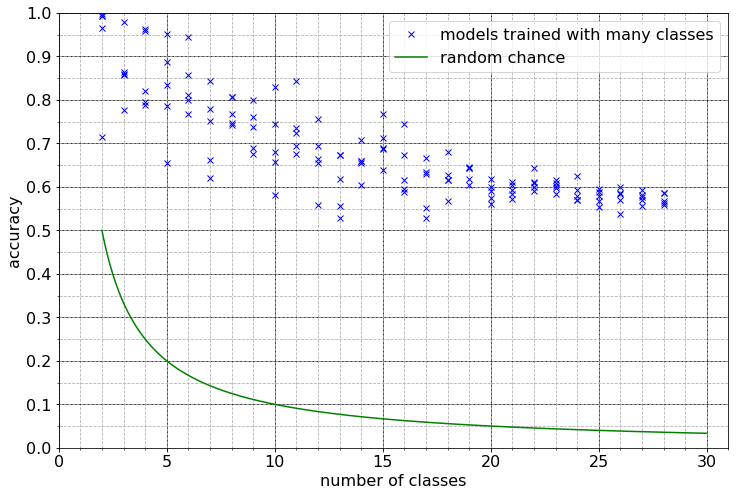

In [11]:
x = np.arange(2,30,0.01)
y = 1/x
plot_acc([data['n'], x], [data['val_categorical_accuracy'], y], ['models trained with many classes', 'random chance'])